In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import time
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
data=pd.read_csv('mnist_train.csv')
idx=np.random.choice(data.index,6000)
data=data.iloc[idx]
data.reset_index(inplace=True)
data.drop(columns='index',inplace=True)
labels=data.iloc[:,0]
data=data.iloc[:, 1:]
dataNorm=data/np.max(data,axis=0)
dataNorm.fillna(0,inplace=True)





In [4]:
dataT=torch.tensor(np.array(dataNorm)).float()
labelsT=torch.tensor(np.array(labels)).long()
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
     

In [12]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [13]:
# inspect the "learning toggle" of a layer
N = createTheMNISTNet()[0]
N.fc1.weight.requires_grad
     

True

In [14]:
for p in N.named_parameters():
  if 'input' not in p[0]:
    print(p)
  


('fc1.weight', Parameter containing:
tensor([[-0.1228, -0.0206,  0.1069,  ...,  0.0559,  0.0121, -0.0506],
        [ 0.0225, -0.0240,  0.0792,  ..., -0.1198,  0.0369, -0.0750],
        [-0.0470, -0.1202,  0.1094,  ..., -0.0563,  0.0793, -0.0607],
        ...,
        [ 0.0353, -0.0308,  0.0239,  ..., -0.0084, -0.0420, -0.0959],
        [ 0.0319,  0.0230,  0.1140,  ..., -0.1249,  0.0328, -0.0980],
        [ 0.0447,  0.0457, -0.0774,  ...,  0.0359, -0.0944, -0.0384]],
       requires_grad=True))
('fc1.bias', Parameter containing:
tensor([-0.0948, -0.0497, -0.0680,  0.0929, -0.0687, -0.0008, -0.1138, -0.1023,
         0.0363,  0.0582,  0.0051,  0.1003,  0.0015,  0.1066, -0.0895, -0.0655,
        -0.1180,  0.0788, -0.0361, -0.0069, -0.1245, -0.1100, -0.0547,  0.0186,
         0.1153, -0.0535, -0.0222, -0.0651, -0.1016, -0.0029,  0.0255,  0.0205],
       requires_grad=True))
('fc2.weight', Parameter containing:
tensor([[-0.0789, -0.0084,  0.0954,  ..., -0.0954,  0.1083,  0.1091],
        [ 

In [15]:
N = createTheMNISTNet()[0]

# switch off all layers except input
for p in N.named_parameters():
  if 'input' not in p[0]:
    p[1].requires_grad = False
  

# check what we've done
for p in N.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


In [16]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):



    
    # NEW: switch off learning in all-but-output layers during first 1/2 of training
    if epochi<(numepochs/2):
      for p in net.named_parameters():
        if 'output' not in p[0]:
          p[1].requires_grad = False
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True
    
    



    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net
     

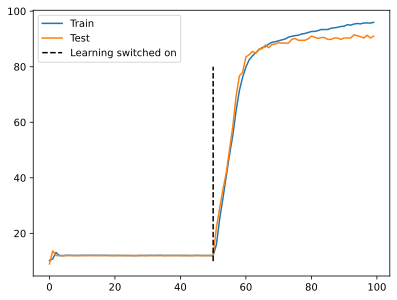

In [17]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()